# GANdy package uses demonstration
Status @ 03.15.21
***

In [1]:
import importlib

In [2]:
# imports
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import sklearn.preprocessing
import sklearn.model_selection

import gandy.quality_est.datagen as gandy_datagen
import gandy.models.gps as gandy_gps
import gandy.models.bnns as gandy_bnns
import gandy.models.gans as gandy_gans
import gandy.optimization.hypersearch as gandy_opt

%matplotlib inline

***

In order to test our models on the ability to predict uncertainty, we synthesized test cases with known uncertainty functions. With these, we can compare the predicted uncertainties to the "true" value.

This was done foundationally as follows:

__Dataset 1__: 
- With some analytical function $f(x_1, x_2)$
- Introduce x dependant noise $g(x_1, x_2)$
- create a dataset of $y(x_1, x_2) = g + f$

__Dataset 2__:
- Repeat above but use QM9 molecular property data instead of an analytical function

## <span style="color:orange"> Loading and preparing the data</span>

In [3]:
df_analytical = gandy_datagen.generate_analytical_data(to_csv=False)
df_analytical.describe()

,X1,X2,Y
count,10000.000000,10000.000000,10000.000000
mean,4.987176,4.975304,0.134098
std,2.887263,2.922002,1.457316
min,0.000455,0.000009,-6.909322
25%,2.474693,2.391601,-0.807557
50%,5.006735,5.015225,0.170740
75%,7.489884,7.518698,1.141935
max,9.999538,9.999657,5.436696


>The data is 2 dimensional in features and one in targets.

<span style="color:red"> NOTE: CHANGED THE ANALYTICAL GENERATION SLIGHTLY TO HAVE A BETTER/MORE INTERPERATBLE DATASET (lower sample range, more points, less noise magnitude. was pretty much all noise before)</span>

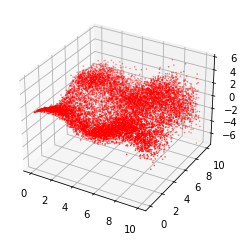

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_analytical['X1'], df_analytical['X2'], df_analytical['Y'], marker='.', color='r', s=1)

> The underlying analytical functions are planwaves, and we see an increase in noise as either X feature gets larger. We would like to reproduce this noise as uncertainty with our models.

In [5]:
## prepare the data as arrays
Xs = df_analytical[['X1', 'X2']].values
Ys = df_analytical['Y'].values.reshape(-1,1)
#. split into train and test
Xsr, Xst, Ysr, Yst = sklearn.model_selection.train_test_split(Xs, Ys, train_size=0.97)

#. scale and normalize our data
norm = sklearn.preprocessing.Normalizer()
scale = sklearn.preprocessing.StandardScaler()
Xsr = norm.fit_transform(Xsr)
Xst = norm.transform(Xst)
Ysr = scale.fit_transform(Ysr)
Yst = scale.transform(Yst)

***

We then instatialize and train our models on these datasets. All models are built on the same class framework so follow the same procedure.

## <span style="color:orange">Gaussian processes</span>

In [5]:
# instantialize the model
gp = gandy_gps.ucGaussianProcess.R(xshape=Xsr.shape[1:],
                                   yshape=Ysr.shape[1:])

In [6]:
# train it on the training data
gp.train(Xsr, Ysr)

In [7]:
# make predictions
gp_preds, gp_uncs = gp.predict(Xst)

/Users/ek/miniconda3/envs/gandy_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


## <span style="color:orange"> Bayesian Neural Networks</span>

In [8]:
# instantialize the model
bnn = gandy_bnns.BNN(xshape=Xsr.shape[1:],
                     yshape=Ysr.shape[1:],
                     train_size=len(Xsr))   # we must also pass the size of the training set, necessary for BNNs to weight the divergence

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


In [9]:
# train it on the training data
bnn.train(Xsr, Ysr, epochs=100)

Epoch 1/100
304/304 [==============================] - 2s 1ms/step - loss: 1.7389 - MSE: 1.9883
Epoch 2/100
304/304 [==============================] - 0s 1ms/step - loss: 1.4874 - MSE: 2.1786
Epoch 3/100
304/304 [==============================] - 0s 1ms/step - loss: 1.4937 - MSE: 2.4088
Epoch 4/100
304/304 [==============================] - 0s 1ms/step - loss: 1.4793 - MSE: 2.2868
Epoch 5/100
304/304 [==============================] - 0s 1ms/step - loss: 1.4570 - MSE: 2.1420
Epoch 6/100
304/304 [==============================] - 0s 1ms/step - loss: 1.4507 - MSE: 2.1701
Epoch 7/100
304/304 [==============================] - 0s 1ms/step - loss: 1.4510 - MSE: 2.0478
Epoch 8/100
304/304 [==============================] - 0s 1ms/step - loss: 1.4554 - MSE: 2.2147
Epoch 9/100
304/304 [==============================] - 0s 1ms/step - loss: 1.4564 - MSE: 2.0923
Epoch 10/100
304/304 [==============================] - 0s 1ms/step - loss: 1.4456 - MSE: 1.9938
Epoch 11/100
304/304 [=================

In [10]:
# make predictions
bnn_preds, bnn_uncs = bnn.predict(Xst)

## <span style="color:orange"> Generative Adversarial Networks</span>

In [13]:
# instantialize the model
gan = gandy_gans.GAN(xshape=Xsr.shape[1:],
                     yshape=Ysr.shape[1:])

In [14]:
# train it on the training data
gan.train(Xsr, Ysr, batches=10000)

Step 1000: 	Avg gen loss 1.0312977125048637, 	Avg discrim loss 1.0506012362241746
Step 2000: 	Avg gen loss 1.0684097777605057, 	Avg discrim loss 0.9848177514076233
Step 3000: 	Avg gen loss 1.082771799981594, 	Avg discrim loss 0.9694629002213478
Step 4000: 	Avg gen loss 1.0932629212141036, 	Avg discrim loss 0.9650449637770653
Step 5000: 	Avg gen loss 1.0932814731001854, 	Avg discrim loss 0.9630258381962776
Step 6000: 	Avg gen loss 1.0950385361909867, 	Avg discrim loss 0.9615688610076905
Step 7000: 	Avg gen loss 1.1016779359579085, 	Avg discrim loss 0.9576533975601196
Step 8000: 	Avg gen loss 1.0910147476196288, 	Avg discrim loss 0.9635934470891953
Step 9000: 	Avg gen loss 1.0989939161539077, 	Avg discrim loss 0.9632411943674087
Step 10000: 	Avg gen loss 1.0981571505069732, 	Avg discrim loss 0.9597116685509681
TIMING: model fitting took 39.363 s


In [15]:
# make predictions
gan_preds, gan_uncs = gan.predict(Xst)

## <span style="color:orange"> Looking back at losses</span>

All of the models store any returned losses/metrics. These can be accessed at the `sessions` attribute for every training session, and additionally if the model accepts loss types other than default it can be specified to the model.

In [16]:
gan.sessions

{'Starttime: 385.4602': [[1.0312977125048637,
   1.0684097777605057,
   1.082771799981594,
   1.0932629212141036,
   1.0932814731001854,
   1.0950385361909867,
   1.1016779359579085,
   1.0910147476196288,
   1.0989939161539077,
   1.0981571505069732,
   1.0981571505069732],
  [1.0506012362241746,
   0.9848177514076233,
   0.9694629002213478,
   0.9650449637770653,
   0.9630258381962776,
   0.9615688610076905,
   0.9576533975601196,
   0.9635934470891953,
   0.9632411943674087,
   0.9597116685509681,
   0.9597116685509681]]}

In [17]:
gen_loss = gan.sessions['Starttime: 385.4602'][0]
dis_loss = gan.sessions['Starttime: 385.4602'][1]

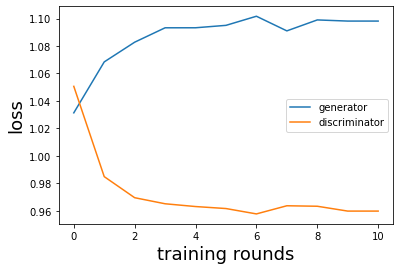

In [18]:
fig, ax = plt.subplots()
ax.plot(gen_loss, label='generator')
ax.plot(dis_loss, label='discriminator')
ax.set_ylabel('loss', size=18)
ax.set_xlabel('training rounds', size=18)
plt.legend()

## <span style="color:orange"> Predictions</span>

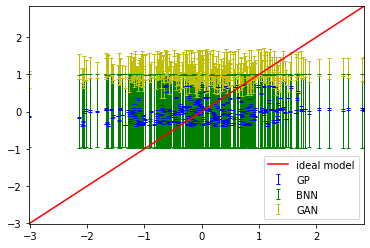

In [20]:
fig, ax = plt.subplots()
minv, maxv = Yst.min(), Yst.max()
ax.set_ylim([minv, maxv])
ax.set_xlim([minv, maxv])
ax.errorbar(Yst, gp_preds, yerr=gp_uncs.reshape(-1), ls='none', label='GP', linewidth=1, capsize=2, c='b')
ax.errorbar(Yst, bnn_preds, yerr=bnn_uncs.reshape(-1), ls='none', label='BNN', linewidth=1, capsize=2, c='g')
ax.errorbar(Yst, gan_preds, yerr=gan_uncs.reshape(-1), ls='none', label='GAN', linewidth=1, capsize=2, c='y')
ax.plot([minv, maxv], [minv, maxv], c='r', label='ideal model')
plt.legend()

All of the models at a galance to pretty poorly!

__GP__: The predicted values are mostly stationary. This is fairly expected given that we have only two features and a very nonlinear function. It also is predicting 0 uncertianty for most quantities.

__BNN__: Something seems very off here, the model predicts the same quantiy and uncertainty for all values.

__GAN__: The model seems to be on track knowing the fickyness of GANs. Also by the descriminator and generator losses diverging we can tell that we need to change some hyperparameters.

***

It might also be desireable to conduct hyperparameter search over a given model type's hyperparameters. This is achieved with the an optimization routine using [Optuna](https://github.com/optuna/optuna)'s code wrapped to fit our Uncertainty Model class.

## <span style="color:orange">Running a hyperparameter optimization</span>

Search for BNN hyperparameters - activation function and learning rate

In [9]:
# define the search space
search_space = {'activation': ['tanh', 'relu', 'sigmoid'],               # signifies a choice
                'optimizer_learning_rate': (0.001, 0.1, 'loguniform')}    # a continues lognormal sample space

# and the optimizing routine
opt = gandy_opt.OptRoutine(subject=gandy_bnns.BNN,
                           Xs=Xsr,
                           Ys=Ysr,
                           search_space=search_space,
                           xshape=Xsr.shape[1:],
                           yshape=Ysr.shape[1:],
                           train_size=len(Xsr))

In [10]:
# run the optimization
opt.optimize(n_trials=10)

Cannot have more than one k, val_data, val_frac. Deleting k
Cannot have more than one k, val_data, val_frac.  Deleting val_data


TypeError: create_study() got an unexpected keyword argument 'xshape'

In [3]:
## Code

***

Finally, we want to evaluate our model on its ability to predict uncertainty, such that future predictions of uncertainty are trusted.

In [1]:
## Code

In [2]:
## Code

In [3]:
## Code